In [1]:
#imports
import nest
import yaml
import nest.raster_plot
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, filtfilt
from analysis_functions import *
from asserting_functions import *
from yaml_io import *
from prepare_nest_parameters import *
from nest_reset_create_connect_simulate import *
from activity_analysis import *
from synaptic_io import *


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Jun 14 2024 10:44:24

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
is_verbose = False
#copy configuration yamls in specified output directory
directories_and_list_of_yamls =\
    read_basic_directories_and_list_of_yamls(is_verbose)
copy_yamls_in_output_dir(directories_and_list_of_yamls, is_verbose)

is_verbose = False
#total sim, resolution and recording times
times = read_sim_and_recording_times_yaml(is_verbose)

#read general network parameters
config = read_general_config_yaml(is_verbose)

#prepare all simulation parameters
nest_pms={}
nest_pms = nest_parameters_preparation(times, config, is_verbose, nest_pms)
print("nest_pms",nest_pms)

in read_directories_yaml: verbose mode is False
in read_sim_and_recording_times_yaml: verbose mode is False
in read_general_config_yaml: verbose mode is False
in nest_parameters_preparation: verbose mode is False
in read_neural_parameters: verbose mode is False
in read_neural_parameters: verbose mode is False
nest_pms {'exc_pms': {'multi_compartment': False, 'neuron_kind': 'excitatory', 'equation_params': {'a': 0, 't_ref': 0.0, 'Delta_T': 2.0, 'C_m': 362.5648533496359, 'g_L': 6.666182946322264, 'tau_w': 500.0, 'V_th': -50.0, 'V_peak': -40.0, 'b_awake': 40.0, 'E_L_awake': -58.656837907086036, 'V_reset_awake': -62.12885359171539, 'b_NREM': 200.0, 'E_L_NREM': -63.656837907086036, 'V_reset_NREM': -62.12885359171539}}, 'inh_pms': {'multi_compartment': False, 'neuron_kind': 'inhibitory', 'equation_params': {'a': 0, 'b': 0, 't_ref': 0.0, 'Delta_T': 2.0, 'C_m': 50.0, 'g_L': 5.0, 'E_L': -63.0, 'V_reset': -65.0, 'tau_w': 500.0, 'V_th': -50.0, 'V_peak': -40.0}}, 'contextual_poisson': {'awake': {'

In [3]:
NEST_version = nest.__version__
if NEST_version == "3.7.0" and nest_pms["use_single_compartment_environment"]==False:
    print("ASSERTION ERROR: Ca-AdEx multi-compartment neuron not supported by this NEST version", NEST_version)
    assert(False)
is_verbose=False
num_threads=4
sim_completed, spike_recorders, inh_spike_recorder = nest_reset_create_connect_simulate(nest_pms,num_threads, is_verbose)
print("sim_completed", sim_completed)

IN nest_reset_create_connect_simulate: use_single_compartment_environment =
Aug 22 09:18:07 SimulationManager::set_status [Info]: 
 True
    Temporal resolution changed from 0.1 to 0.1 ms.
in nest_..._simulate: just before nest.Simulate
nest_pms['events_pms'] [{'action': {'kind': 'store_intra_assembly_syn', 'file_name': 'first_syn_matrix'}}, {'action': {'kind': 'disconnect_intra_exc_pop_syn', 'target_exc_pop': 2}, 'sim_period_ms': 100.0}, {'action': {'kind': 'store_intra_assembly_syn', 'file_name': 'second_syn_matrix'}, 'sim_period_ms': 100.0}]
ACTION {'kind': 'store_intra_assembly_syn', 'file_name': 'first_syn_matrix'}
in perform_event_action: requested action: {'kind': 'store_intra_assembly_syn', 'file_name': 'first_syn_matrix'}
in store_intra_assembly_synapses:
will save to file: first_syn_matrix
ACTION {'kind': 'disconnect_intra_exc_pop_syn', 'target_exc_pop': 2}
in perform_event_action: requested action: {'kind': 'disconnect_intra_exc_pop_syn', 'target_exc_pop': 2}
expected NEXT S

In [4]:
d_inh = nest.GetStatus(inh_spike_recorder, "events")[0]

In [5]:
#before analysis, preliminary sim look 
is_verbose=True
preliminary_sim_look(is_verbose, nest_pms, spike_recorders, inh_spike_recorder, nest_pms["recording_pms"])   

pop 0 first recorded event at time 631.6 from sender 16
pop 0 last recorded event at time 44093.0 from sender 19
pop 0 total_exc_pop_spikes= 580
pop 0 average_exc_pop_firing_rate_Hz= 0.6444444444444445 Hz
pop 1 first recorded event at time 426.2 from sender 24
pop 1 last recorded event at time 44924.9 from sender 27
pop 1 total_exc_pop_spikes= 580
pop 1 average_exc_pop_firing_rate_Hz= 0.6444444444444445 Hz
pop 2 first recorded event at time 594.8000000000001 from sender 48
pop 2 last recorded event at time 44883.700000000004 from sender 55
pop 2 total_exc_pop_spikes= 387
pop 2 average_exc_pop_firing_rate_Hz= 0.43000000000000005 Hz
pop 3 first recorded event at time 172.8 from sender 76
pop 3 last recorded event at time 43568.1 from sender 71
pop 3 total_exc_pop_spikes= 520
pop 3 average_exc_pop_firing_rate_Hz= 0.5777777777777778 Hz
INHIBITORIES 3 first recorded event at time 187.5 from sender 84
INHIBITORIES 3 last recorded event at time 44925.3 from sender 99
INHIBITORIES 3 total_inh_

In [6]:
is_verbose=False
#here we prepare all the parameters for the following analysis and print
crop_pms, plot_pms, sampling_pms, analysis_pms =\
    prepare_crop_plot_sampling_activityAnalysis_parameters(directories_and_list_of_yamls, nest_pms, is_verbose)

# Assuming spike_recorders is a list of spike recorder IDs previously created in your NEST simulation
cropped_events = crop_events_from_spike_recorders(crop_pms, spike_recorders)
cropped_inh_events = crop_inh_events(crop_pms, inh_spike_recorder)

in read_crop_and_plot_yaml: verbose mode is False
---RECORDING INTERVAL---
start recording at time 0.0 ms
stop recording at time 45000.0 ms
recording_duration 45000.0 ms
---CROPPING INTERVAL
crop start at time 0.0 ms
crop stop at time 45000.0 ms
crop duration 45000.0 ms
---HIGH FREQ analysis AND (spikes) 
spectogram window 4000.0 ms
lower_detectable_frequency 0.25 Hz
spikes sampling window 0.2 ms
analysis sampling freq 5000.0 Hz
max nyquist frequency 2500.0 Hz
----LOW FREQ analysis (ECG, LFP like)
(low freq) spectrogram window 4000.0 ms
lower_detectable_frequency 0.25 Hz
low freq sampling window 12.5 ms
low freq sampling freq 80.0 Hz
(low_freq) max nyquist frequency 40.0 Hz
(low freq) spectrogram window 4000.0 ms


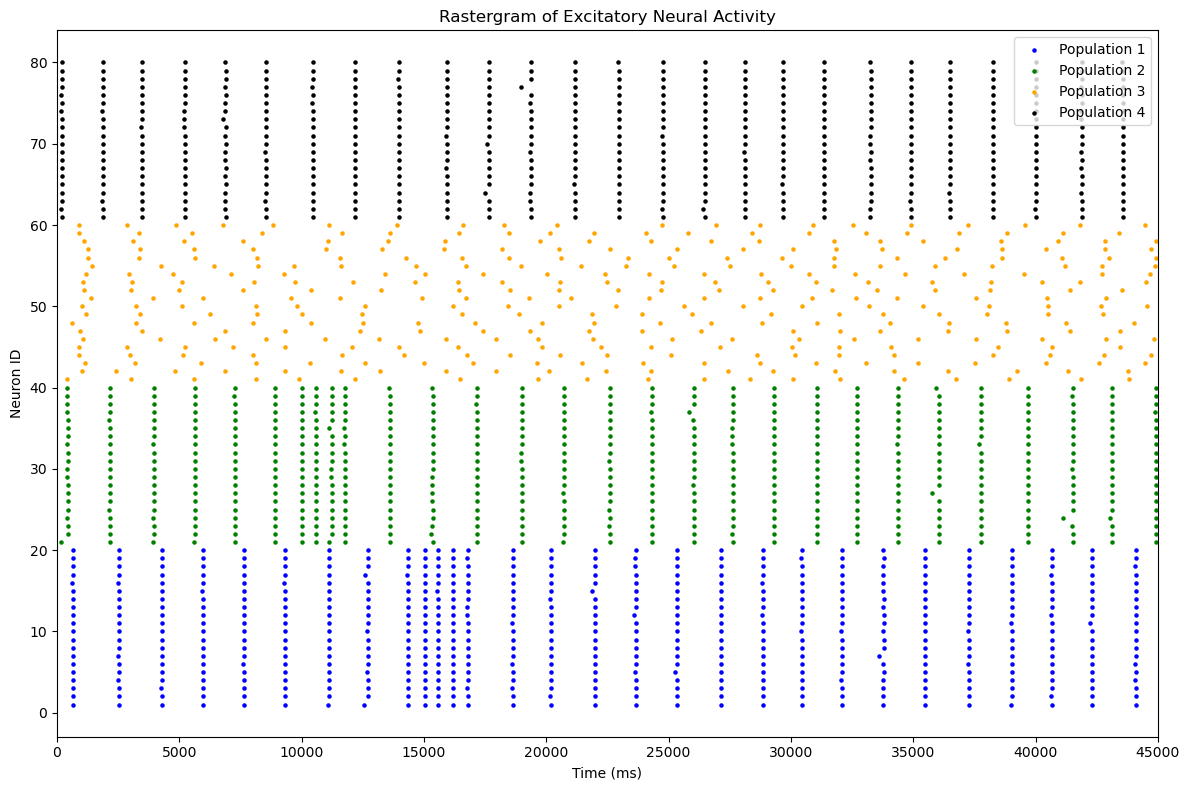

FROM SPIKE-LIKE WAVEFORMS:
--------------------------


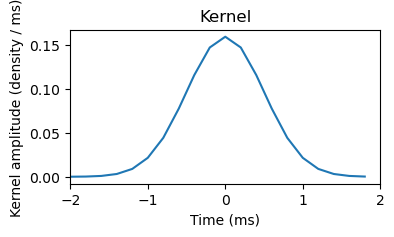

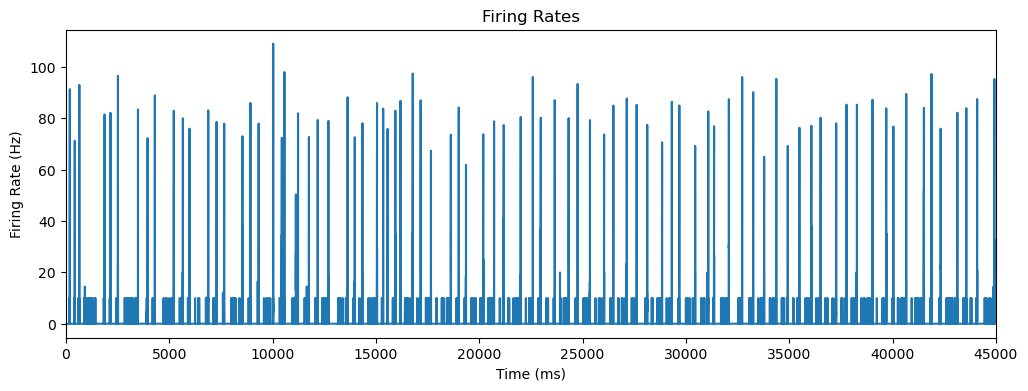

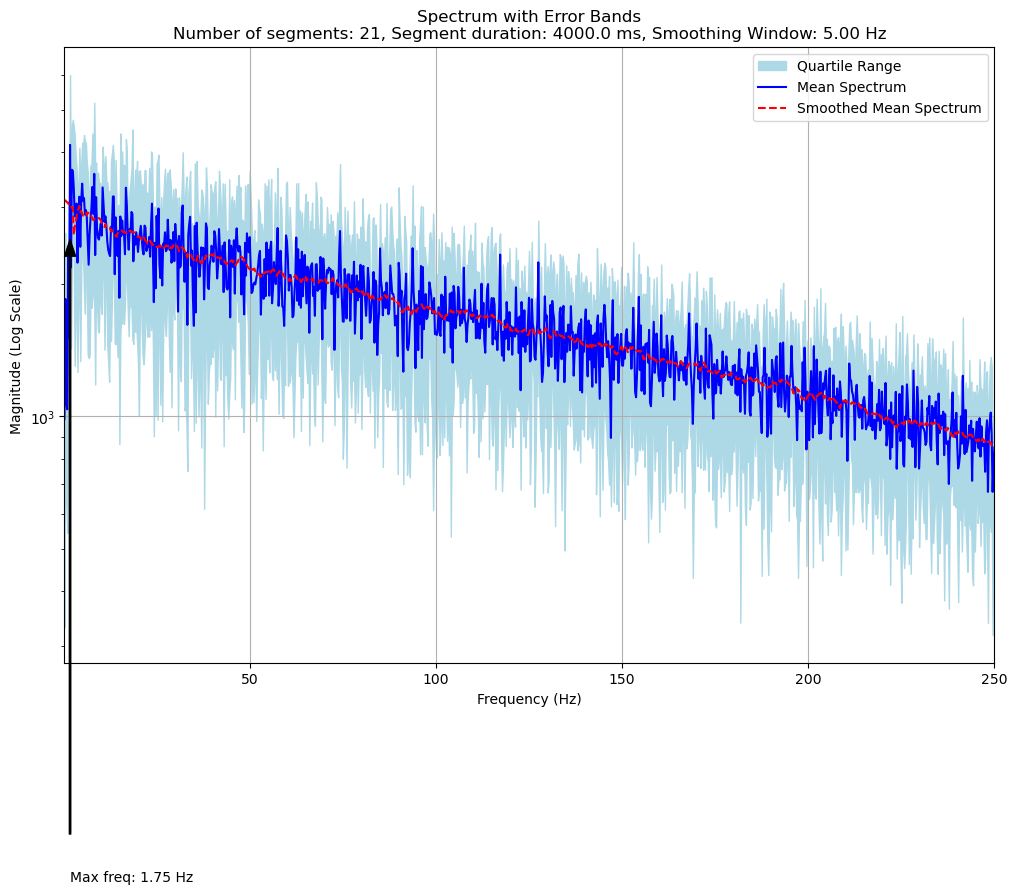

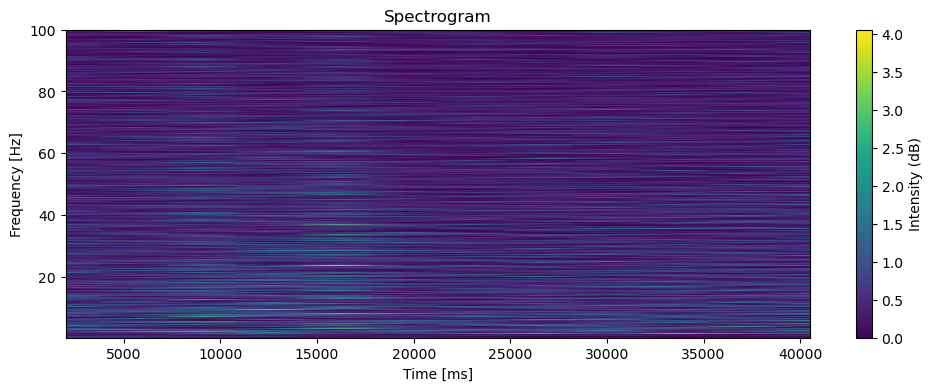

--------------------------
FROM TISSUE-LIKE WAVEFORMS 
--------------------------


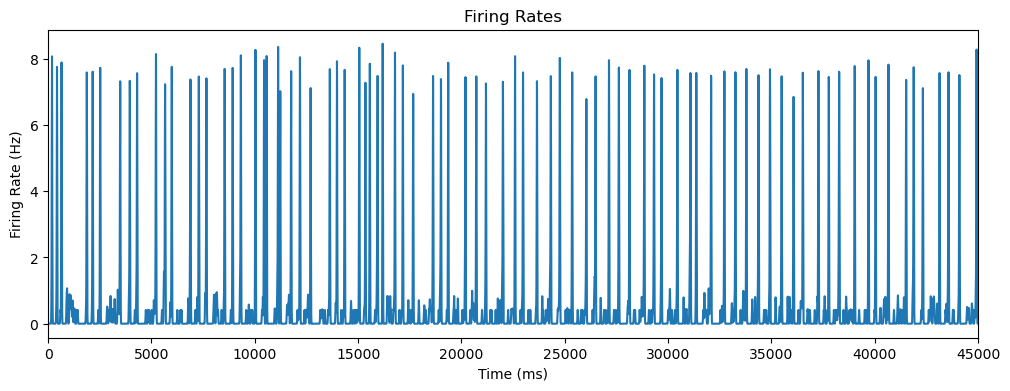

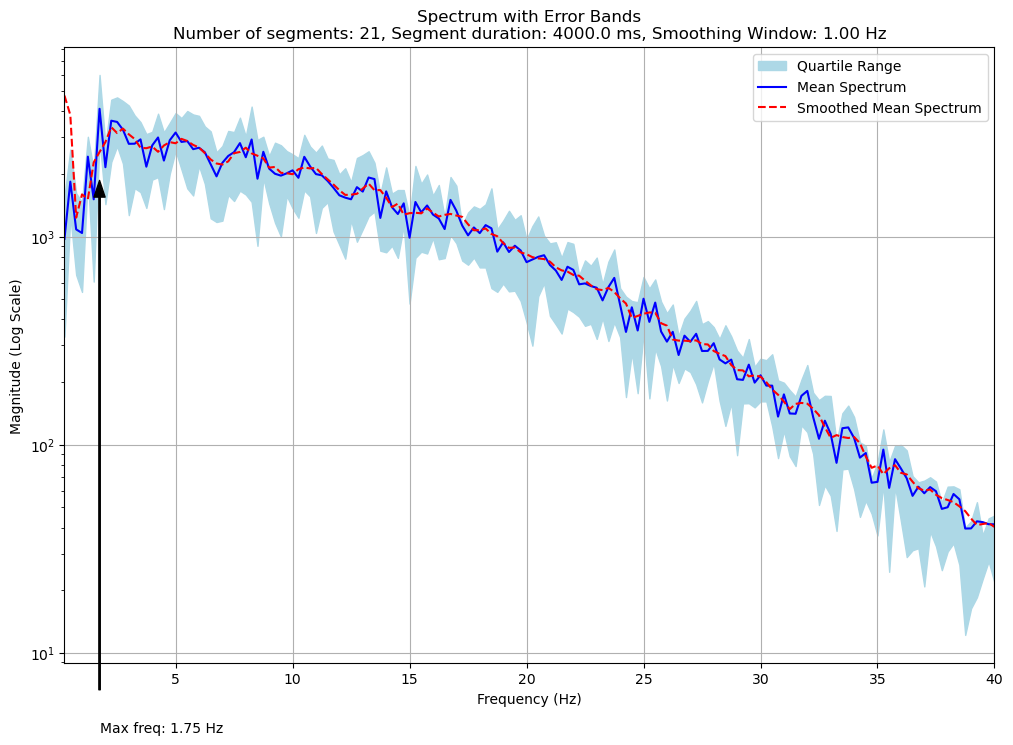

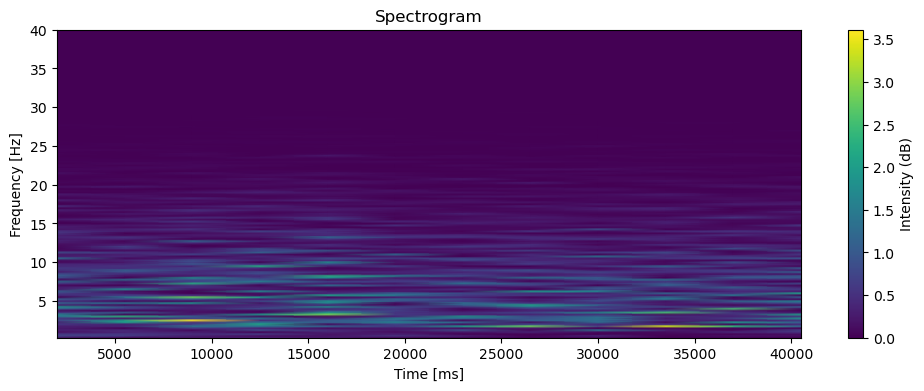

In [7]:
is_verbose=False
#launches all analysis
#produces from both spike-like waveforms and tissue-like responses
#PLEASE use the basic_ and tune_crop_and_plot.yaml to select plots and parameters 
produce_rastegrams_rates_spectra_spectrograms(directories_and_list_of_yamls,\
    nest_pms, crop_pms, plot_pms, analysis_pms, cropped_events, cropped_inh_events, is_verbose)

In [8]:
verbose=True
# loading a synaptic matrix
array_of_dicts=load_intra_assembly_syn('first_syn_matrix', verbose) 

in load_intra_assembly_syns:
reading from file: first_syn_matrix


In [9]:
print(array_of_dicts[0]['intra_pop_connections'])

    source  target  weight
1        1       2    19.0
1        1       6    19.0
1        1      10    19.0
1        1      18    19.0
1        1      14    19.0
..     ...     ...     ...
20      20       7    19.0
20      20      11    19.0
20      20      15    19.0
20      20      19    19.0
20      20       3    19.0

[380 rows x 3 columns]


In [10]:
verbose=True
# loading a synaptic matrix
array_of_dicts=load_intra_assembly_syn('second_syn_matrix', verbose) 

in load_intra_assembly_syns:
reading from file: second_syn_matrix


In [11]:
print(array_of_dicts[0]['intra_pop_connections'])

    source  target  weight
1        1       4    19.0
1        1      12    19.0
1        1      16    19.0
1        1      20    19.0
1        1       8    19.0
..     ...     ...     ...
20      20       6    19.0
20      20      18    19.0
20      20      14    19.0
20      20      10    19.0
20      20       2    19.0

[380 rows x 3 columns]
